## Packages

If in Google Colab, uncomment:

In [ ]:
#!pip install spectrum
#!pip install dtw-python
#!pip install dtreeviz
#!pip install sktime
#!pip install pmdarima
#!pip install statsmodels

In [1]:
import time
import timeit
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
#import seaborn as sns

from math import sqrt

import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from scipy import stats

#%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

## Load data

In [2]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

### ETL 5 minutes

In [3]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df = df.set_index('Date')
df_5 = df.resample('5T').mean()
df_5.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5547.831152,4353.258496,4927.916309,1355.909058,1697.601026,3396.820703,920.982605
2010-01-01 00:05:00,5535.618164,4348.893457,4916.344433,1353.716626,1699.889233,3397.829590,918.181799
2010-01-01 00:10:00,5529.010351,4331.776856,4897.709473,1346.924121,1697.138647,3424.317334,916.371033
2010-01-01 00:15:00,5514.982032,4330.051758,4879.650098,1346.241382,1705.324194,3421.112500,916.161291
2010-01-01 00:20:00,5472.567285,4314.503906,4863.172266,1334.846802,1674.401562,3409.312451,914.513721


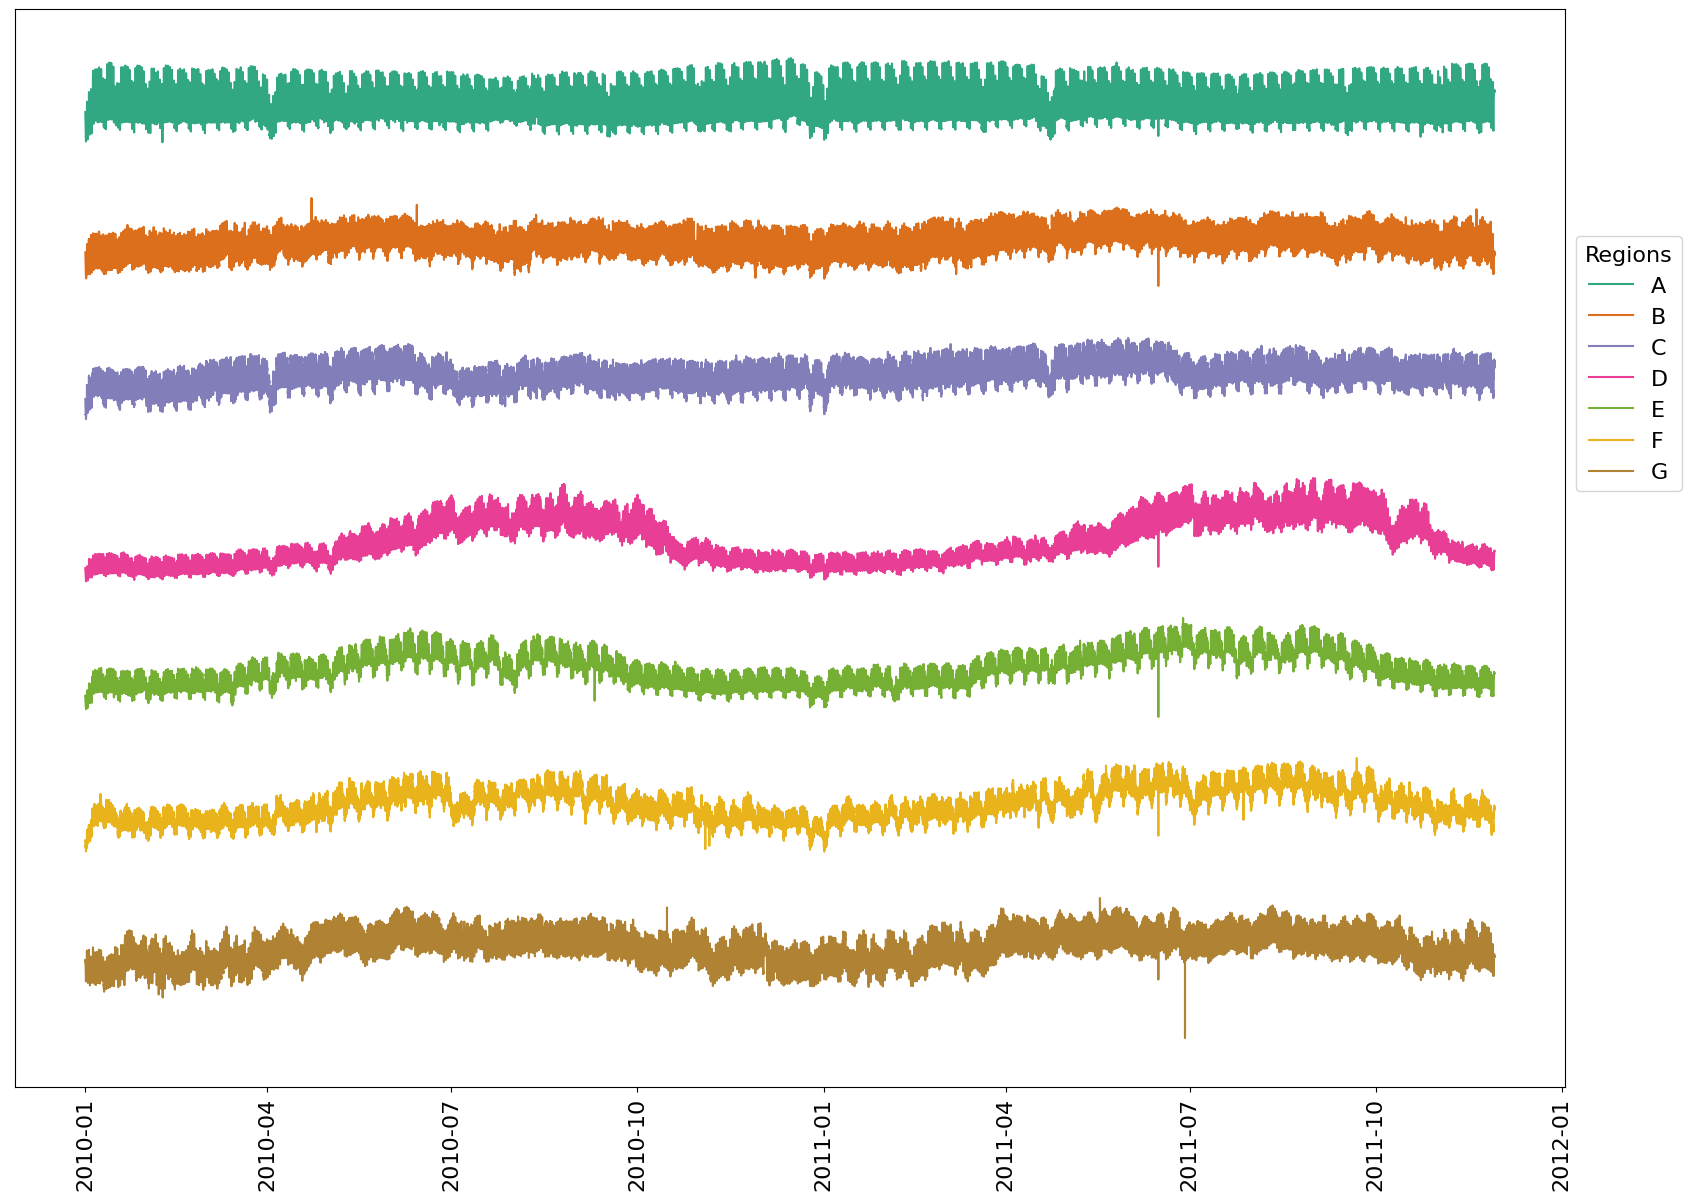

In [4]:
regions = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
if  True:
  i = 0
  j = 0
  cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
  fig, ax = plt.subplots(figsize=(20,14))
  for ts in df_5:
    max_t = df_5[ts].max()
    plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label=regions[i], alpha=.9)
    i += 1
    j -= 1
  plt.yticks([])
  plt.xticks(rotation=90, fontsize=16)
  plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16}, title="Regions", title_fontsize=16)
  #plt.savefig('series.pdf', bbox_inches = 'tight')
  plt.show()

## Functions

### Sample selection

In [5]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [6]:
def diff(list1,list2):
    difference = []
    zip_object = zip(list1, list2)
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    return difference

In [7]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [8]:
#https://thispointer.com/python-how-to-append-a-new-row-to-an-existing-csv-file/#:~:text=Open%20our%20csv%20file%20in,in%20the%20associated%20csv%20file
from csv import writer
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
# a=1234566; b=987
# row = [a,b]
# append_list_as_row('test.csv',row)

### Utilities

In [9]:
## Function that given a datetime, returns its position in the series.
def get_index_day(df,day,month,year):
    df_i = df.reset_index()  ## Integer indices are added.
    idxo = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[ 0]
    idxf = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[-1]
    return(idxo.name, idxf.name)

In [10]:
def get_day_from_index(df, indices, forecast):
    """
    Parameters
    ----------
    df : DataFrame
        Original dataframe of the timeseries
    indices : array
        Array of indices
    
    Returns
    -------
    DataFrame
        A DataFrame of dates
    """
    df_i = df.reset_index()  ## Integer indices are added.
    sel_date = df_i.iloc[indices].Date
    t = pd.concat([sel_date.reset_index(), pd.Series(forecast)], axis=1)
    t = t.rename(columns={0 : 'value'})
    return(t)

# Prepare cross-validation for testing

We will use the methodology proposed by Rob J Hyndman [cross-validation in time series](https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
), that is a training dataset of four months followed by a testing dataset of the next month.


In [11]:
## https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
## ... year 2010                                                                                                    year 2011
## ... january···february···march···april···may···june···july···august···september···october···november···december···january···february···march···april···may···june···july···august···september···october···november
##    |                                   |      |
##    |<------------- train ------------->|<test>|
##    |<-january·february···march···april->|<may>|
##            |<-february···march···april···may->|<june>|
##                      |<- march···april···may···june ->|<-july->|
##                              |<- april···may···june···july->|<-august->|
##                                     |<-- may···june···july···august->|<-september->|
##                                             |<-june···july···august···september->|<-october->|
##                                                    |<-july···august···september···october->|<-november->|
##                                                           |<-august···september···october···november->|<-december->| ...

df_5_month = df_5.copy()
df_5_month.reset_index(inplace=True)
# https://stackoverflow.com/a/25149272
df_5_month['month'] = df_5_month['Date'].dt.month
df_5_month['year' ] = df_5_month['Date'].dt.year
df_5_month = df_5_month.drop_duplicates(['month', 'year'])
df_5_month.index

Int64Index([     0,   8928,  16992,  25920,  34560,  43488,  52128,  61056,
             69984,  78624,  87552,  96192, 105120, 114048, 122112, 131040,
            139680, 148608, 157248, 166176, 175104, 183744, 192672],
           dtype='int64')

# Parameter and series selection

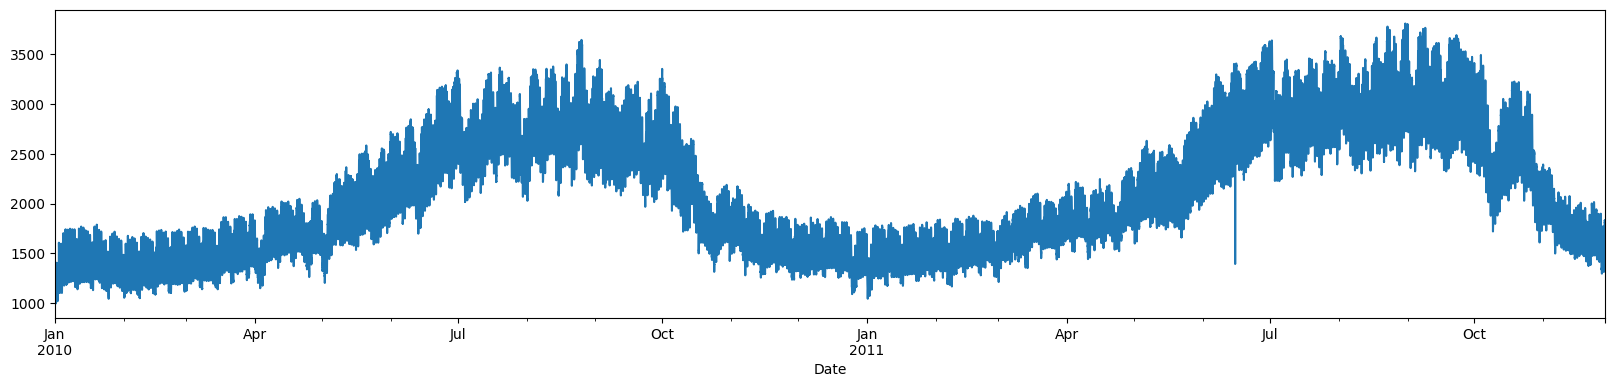

In [12]:
serie4 = df_5.SERIE4
plt.figure(figsize=(20, 4))
#plt.savefig('series1.pdf', bbox_inches = 'tight')
serie4.plot()
plt.show()

In [13]:
df_serie4 = serie4.reset_index()
df_serie4.columns = ['date', 'value']
df_serie4

,date,value
0,2010-01-01 00:00:00,1355.909058
1,2010-01-01 00:05:00,1353.716626
2,2010-01-01 00:10:00,1346.924121
3,2010-01-01 00:15:00,1346.241382
4,2010-01-01 00:20:00,1334.846802
...,...,...
200634,2011-11-28 15:30:00,1824.311914
200635,2011-11-28 15:35:00,1832.722339
200636,2011-11-28 15:40:00,1830.256812
200637,2011-11-28 15:45:00,1824.559302


In [14]:
## ene2010... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·nov2011
##                |                                               |       |           |
##                |                                               |<-n_p->|           |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt   ...j=0...      tf 

n_p       = 30         ## Number of periods per step (Two and half hour)
vsele     = 288        ## Number of periods in a window (a day)
namefile  = 'forecast'
monthyear = 'jun2010'

##  21 Junio 2010       - 21 Septiembre 2010   Verano
##  21 Septiembre 2010  - 21 Diciembre 2010    Otoño
##  21 Diciembre 2011   - 21 Marzo 2011        Invierno
##  21 Marzo 2011       - 21 Junio 2011        Primavera

In [15]:
df_serie4_summer = df_serie4[(df_serie4.date >='2010-06-21')&(df_serie4.date <'2010-09-21')]

In [16]:
# Each season
df_serie4_summer = df_serie4[(df_serie4.date >='2010-06-21')&(df_serie4.date <'2010-09-21')]
df_serie4_autum  = df_serie4[(df_serie4.date >='2010-09-21')&(df_serie4.date <'2010-12-21')]
df_serie4_winter = df_serie4[(df_serie4.date >='2010-12-21')&(df_serie4.date <'2011-03-21')]
df_serie4_spring = df_serie4[(df_serie4.date >='2011-03-21')&(df_serie4.date <'2011-06-21')]

## Unit test per season

In [17]:
df_serie4_summer

,date,value
49248,2010-06-21 00:00:00,2830.813281
49249,2010-06-21 00:05:00,2827.722998
49250,2010-06-21 00:10:00,2829.968164
49251,2010-06-21 00:15:00,2830.823340
49252,2010-06-21 00:20:00,2830.045606
...,...,...
75739,2010-09-20 23:35:00,3033.962793
75740,2010-09-20 23:40:00,3024.287891
75741,2010-09-20 23:45:00,3021.757666
75742,2010-09-20 23:50:00,3011.382813


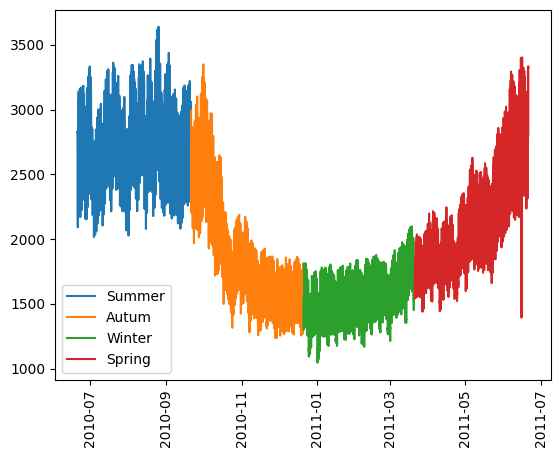

In [18]:
plt.figure()
plt.plot(df_serie4_summer.date, df_serie4_summer.value, label = 'Summer')
plt.plot(df_serie4_autum.date , df_serie4_autum.value , label = 'Autum')
plt.plot(df_serie4_winter.date, df_serie4_winter.value, label = 'Winter')
plt.plot(df_serie4_spring.date, df_serie4_spring.value, label = 'Spring')
plt.xticks(rotation = 90)
plt.legend()
#plt.savefig('series2.pdf', bbox_inches = 'tight')
plt.show()

In [19]:
# Data selection for season; i.e. summer
indices = df_serie4_summer.date - pd.DateOffset(months=4) # select indices
df_serie4_summer_data = df_serie4[
  (df_serie4.date >= indices.values[0]) & (df_serie4.index < df_serie4_summer.index[0])
]
df_serie4_summer_data # train

,date,value
14688,2010-02-21 00:00:00,1391.671289
14689,2010-02-21 00:05:00,1372.883789
14690,2010-02-21 00:10:00,1364.407349
14691,2010-02-21 00:15:00,1353.405566
14692,2010-02-21 00:20:00,1342.204419
...,...,...
49243,2010-06-20 23:35:00,2799.613428
49244,2010-06-20 23:40:00,2810.940430
49245,2010-06-20 23:45:00,2817.902002
49246,2010-06-20 23:50:00,2828.313135


In [20]:
t0 = df_serie4_summer_data.iloc[0]  # initial time
tt = df_serie4_summer_data.iloc[-1] # time to
tf = df_serie4_summer.iloc[-1]      # final time

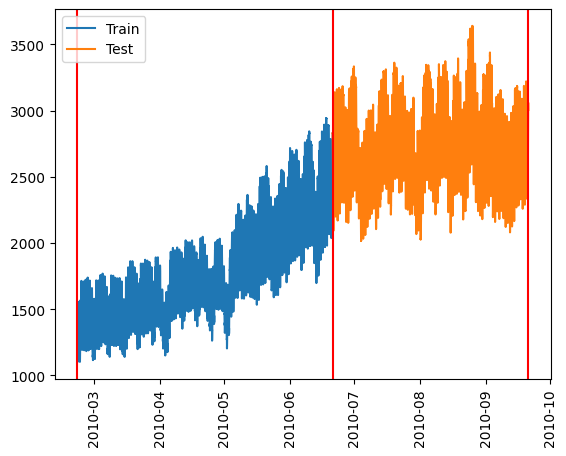

In [21]:
plt.figure()
plt.plot(df_serie4_summer_data.date, df_serie4_summer_data.value, label = 'Train')
plt.plot(df_serie4_summer.date, df_serie4_summer.value, label = 'Test')
plt.xticks(rotation = 90)
plt.axvline(x = t0.date, c = 'red')
plt.axvline(x = tt.date, c = 'red')
plt.axvline(x = tf.date, c = 'red')
plt.legend()
plt.show()

In [22]:
# Access index of t0, etc ╰（‵□′）╯
t0.name

14688

In [23]:
def train_test_season(data, d0 = '2010-06-21', df = '2010-09-21', do = 4, verbose = False):
  # d0: start date
  # df: final date
  # d0: offset date in months
  # df_r: df result
  # t0: start train index
  # tt: end train index / start test index
  # tf: end test index
  df_r = data[(data.date >= d0) & (data.date < df)]
  if verbose:
    plt.figure()
    plt.plot(df_r.date, df_r.value, label = 'df_r')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

  # Data selection for range(d0, df)
  indices = df_r.date - pd.DateOffset(months = do) # select indices
  df_r_data = df_serie4[
    (df_serie4.date >= indices.values[0]) & (df_serie4.index < df_r.index[0])
  ]
  t0 = df_r_data.iloc[0]  # initial time
  tt = df_r_data.iloc[-1] # time to
  tf = df_r.iloc[-1]      # final time

  if verbose:
    plt.figure()
    plt.plot(df_r_data.date, df_r_data.value, label = 'Train')
    plt.plot(df_r.date, df_r.value, label = 'Test')
    plt.xticks(rotation = 90)
    plt.axvline(x = t0.date, c = 'red')
    plt.axvline(x = tt.date, c = 'red')
    plt.axvline(x = tf.date, c = 'red')
    plt.legend()
    plt.show()
  
  return (t0, tt, tf)

In [24]:
# t0, tt, tf = train_test_season(df_serie4, d0 = '2010-06-21', df = '2010-09-21', do = 4, verbose = False) #summer
t0, tt, tf = train_test_season(df_serie4, d0 = '2010-09-21', df = '2010-12-21', do = 4, verbose = False) #autom
# t0, tt, tf = train_test_season(df_serie4, d0 = '2010-12-21', df = '2011-03-21', do = 4, verbose = False) #winter
# t0, tt, tf = train_test_season(df_serie4, d0 = '2011-03-21', df = '2011-06-21', do = 4, verbose = False) #spring

#print(t0, tt, tf)
print(t0.name, tt.name, tf.name) # indices
t0=t0.name
tt=tt.name
tf=tf.name

40320 75743 101951


# Multi-period forecast metafunction **II**:

## Test series

In [25]:
serie1 = serie4.to_numpy(serie4)
serie1

array([1355.9090576 , 1353.7166262 , 1346.924121  , ..., 1830.2568116 ,
       1824.5593018 , 1825.84985367])

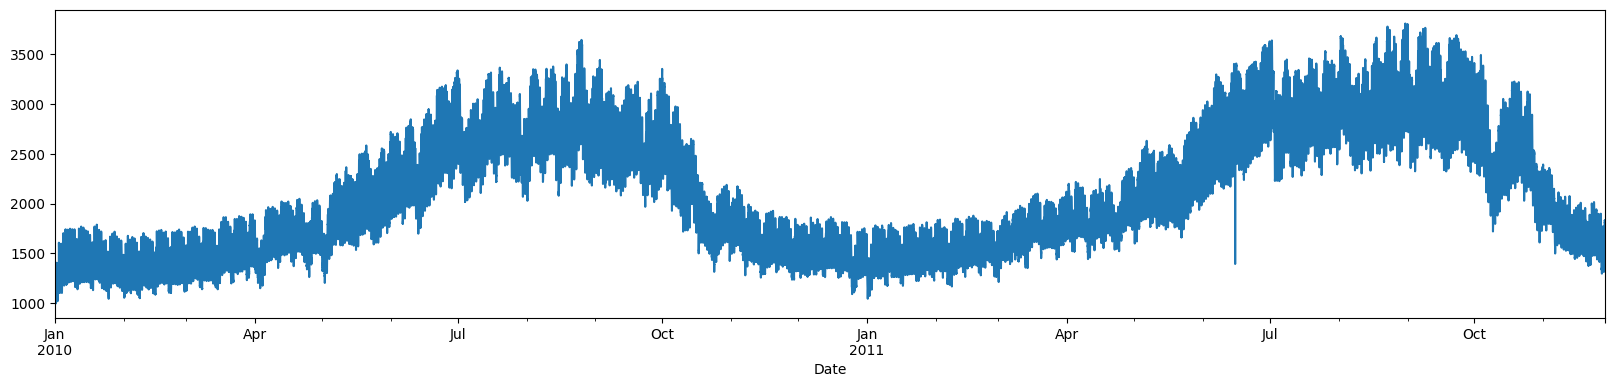

In [26]:
plt.figure(figsize=(20, 4))
#plt.savefig('series1.pdf', bbox_inches = 'tight')
serie4.plot()
plt.show()

In [27]:
## Prepare the test series (real data)

positions_test = [(t0, tt, tf)]

## NIXTLA Test

In [28]:
from statsforecast.models import SeasonalNaive

/home/uriel/.local/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [29]:
df_serie4 = df_5[['SERIE4']]
model = SeasonalNaive(season_length = 288 * 7)
model = model.fit(y = df_serie4.SERIE4.values)
y_hat_dict = model.predict(h = 12 * 2 * 24)

# La serie pronosticada
pd.Series(y_hat_dict['mean'])

0      1672.356689
1      1668.348145
2      1667.355713
3      1666.464233
4      1669.918579
          ...     
571    1878.478394
572    1875.030273
573    1879.136108
574    1885.959106
575    1884.372314
Length: 576, dtype: float32

In [30]:
# Rango de fechas del pronóstico
idx = pd.date_range(
    start = df_serie4.index[-1], 
    periods = len(pd.Series(y_hat_dict['mean'])) + 1, freq='5T')[1:]
idx

DatetimeIndex(['2011-11-28 15:55:00', '2011-11-28 16:00:00',
               '2011-11-28 16:05:00', '2011-11-28 16:10:00',
               '2011-11-28 16:15:00', '2011-11-28 16:20:00',
               '2011-11-28 16:25:00', '2011-11-28 16:30:00',
               '2011-11-28 16:35:00', '2011-11-28 16:40:00',
               ...
               '2011-11-30 15:05:00', '2011-11-30 15:10:00',
               '2011-11-30 15:15:00', '2011-11-30 15:20:00',
               '2011-11-30 15:25:00', '2011-11-30 15:30:00',
               '2011-11-30 15:35:00', '2011-11-30 15:40:00',
               '2011-11-30 15:45:00', '2011-11-30 15:50:00'],
              dtype='datetime64[ns]', length=576, freq='5T')

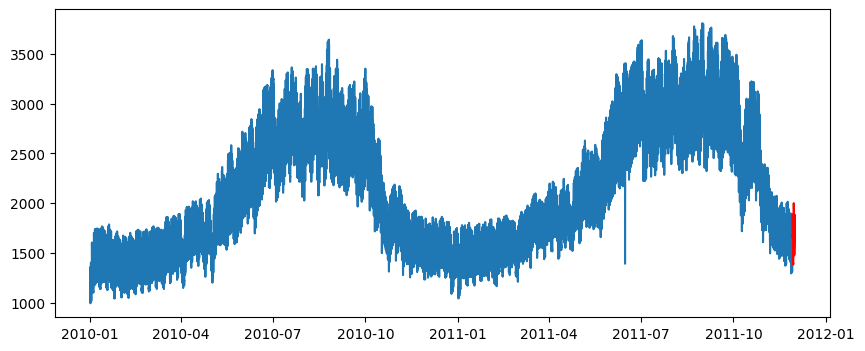

In [31]:
# Última fecha disponible
df_serie4.index[-1]
plt.figure(figsize=(10, 4))
#plt.savefig('series1.pdf', bbox_inches = 'tight')
plt.plot(df_serie4)
plt.plot(pd.DataFrame(y_hat_dict['mean'], index = idx), c = 'red')
plt.show()

In [32]:
positions_test

[(40320, 75743, 101951)]

In [ ]:
timeAn_         = []
forecastAn_     = []
forecastX_An_   = []
row             = []
rowX            = []
row2            = []
rowX2           = []
n_p             = n_p        ## Number of periods per step
nfail           = 0
fail_           = False
vsele           = vsele      ## Number of periods in a window

for to,tt,tf in positions_test:
    j=0
    s=n_p
    for i in range(tt,tf,1):
        X_train = np.array(serie1[to+j:tt+j])
        t_o = time.time()
        try:
            #pred_, t_sel_, t_reg_, fail_, positions = analogo_knn(X_train, vsele=vsele, verbose=False)
            model = SeasonalNaive(season_length = 288 * 7)
            model = model.fit(y = X_train) #df_serie4.SERIE4.values
            y_hat_dict = model.predict(h = 12 * 2 * 24)            
            pred_ = pd.Series(y_hat_dict['mean']) # La serie pronosticada
        except:
            print("!!! Error has occurred in the position:",tt+j)
            # row = ['!!! Error has occurred in the position:',tt+j]
            # append_list_as_row('LogAn.csv',row)
        if fail_==True:              
            nfail = nfail + 1
            print(">>> Persistence forecast in position:",tt+j)
        pred_list  = pred_.tolist()
        forecastAn_ = forecastAn_ + pred_list[0:1]
        row = [tt+j] + [time.time() - t_o] + pred_list[0:1]
        append_list_as_row('SeaNaive.csv',row)
        print(j+tt)

        if s==n_p:
            forecastX_An_   = forecastX_An_ + pred_list[0:n_p]
            for val in pred_list[0:n_p]:
                row = [tt+j] + [time.time() - t_o] + [val]
                append_list_as_row('XSeaNaive.csv',row)
            s=0

        timeAn_.append(time.time() - t_o)
        j = j + 1
        s = s + 1

    modu=(tf-tt)%n_p
    if modu != 0:
        end=min(len(forecastAn_),len(forecastX_An_))
        print('modu',modu)
        forecastAn_     = forecastAn_[    0:end]
        
print('>>> Number of forecasts not calculated:', nfail)

# LEER ARCHIVO

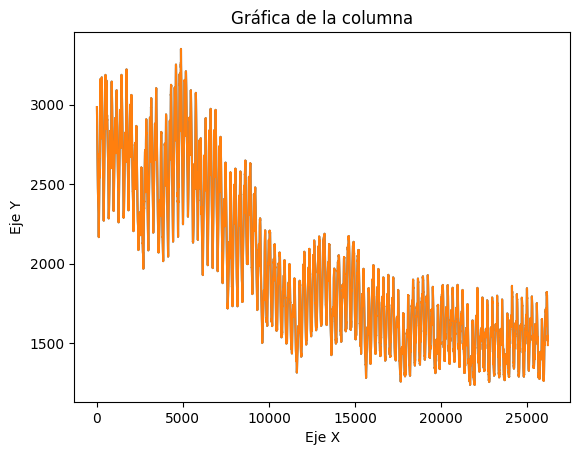

In [37]:

# Leer el archivo CSV sin encabezados
data  = pd.read_csv('SeaNaive.csv',  header=None)
data2 = pd.read_csv('XSeaNaive.csv', header=None)

# Obtener los datos de la tercera columna (índice 2)
columna = data.iloc[:, 2]
columna2 = data2.iloc[:, 2]

# Crear la gráfica
plt.plot(columna)
plt.plot(columna2)

# Agregar etiquetas y título
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Gráfica de la columna')

# Mostrar la gráfica
plt.show()

In [34]:
data

,75743,0.0013790130615234375,2984.091064453125
0,75744,0.001537,2968.600830
1,75745,0.001409,2956.645264
2,75746,0.001362,2949.835938
3,75747,0.001293,2945.279785
4,75748,0.001262,2938.586670
...,...,...,...
26202,101946,0.001387,1526.838257
26203,101947,0.001236,1515.609009
26204,101948,0.001265,1524.490356
26205,101949,0.001258,1540.172729
